In [1]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import matplotlib.path as mpath
from xhistogram.xarray import histogram

In [2]:
df = pd.read_excel('Coral_Locations.xlsx',engine='openpyxl')

In [27]:
locinit = "Drake"
timedir = "back"
runtime = 30*365 # days

fileout = ("output"
           +".locinit_"+locinit
           +".timedir_"+timedir
           +".ntime_"+str(runtime)+".nc")

ds = xr.open_dataset(fileout)

ds['init_lon'] = ds['lon'].isel(obs=0)*xr.ones_like(ds['lon'])
ds['init_lat'] = ds['lat'].isel(obs=0)*xr.ones_like(ds['lat'])
ds['init_z'] = ds['z'].isel(obs=0)*xr.ones_like(ds['z'])
ds['init_T'] = ds['T'].isel(obs=0)*xr.ones_like(ds['T'])
ds['init_S'] = ds['S'].isel(obs=0)*xr.ones_like(ds['S'])
dsall = ds.copy()

In [45]:
ds = dsall.copy()
# Pick shortened time series
ds = ds.isel(obs=slice(0,60))

In [46]:
sites = ['BB','CH','SS','IS','SFZ']

conds = {}
conds['BB'] = (ds['init_lat']<-54)&(ds['init_lat']>-55) & (ds['init_z']<-300)&(ds['init_z']>-1900)
conds['CH'] = (ds['init_lat']<-57)&(ds['init_lat']>-58) & (ds['init_z']<-450)&(ds['init_z']>-1900)
conds['SS'] = (ds['init_lat']<-59)&(ds['init_lat']>-60) & (ds['init_z']<-690)&(ds['init_z']>-1700)
conds['IS'] = (ds['init_lat']<-60)&(ds['init_lat']>-61) & (ds['init_z']<-1000)&(ds['init_z']>-1200)
conds['SFZ'] = (ds['init_lat']<-60)&(ds['init_lat']>-61) & (ds['init_z']<-810)&(ds['init_z']>-830)

colors={'BB':'tab:blue',
        'CH':'tab:orange',
        'SS':'tab:green',
        'IS':'tab:purple',
        'SFZ':'tab:gray'}

In [73]:
sites = ['pink','orange','green']
locs = {'pink':{'lat':[-60.5,-59.5],'depth':[-1200,-600]},
       'orange':{'lat':[-60.5,-59.5],'depth':[-1800,-1600]},
       'green':{'lat':[-57.5,-56.5],'depth':[-2000,-400]}}
conds = {}
for loc in locs.keys():
    latV = locs[loc]['lat']
    depthV = locs[loc]['depth']
    conds[loc] = ((ds['init_lat']>latV[0])
                  &(ds['init_lat']<latV[1]) 
                  &(ds['init_z']>depthV[0])
                  &(ds['init_z']<depthV[1]))
colors={}
for site in sites:
    colors[site] = 'tab:'+site

In [74]:
dssite = {}
for site in sites:
    dssite[site] = ds.where(conds[site]).dropna('traj')

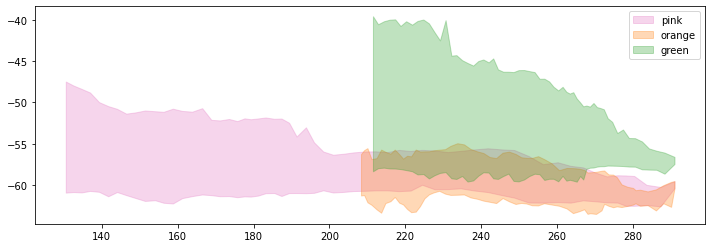

In [76]:
fig,ax = plt.subplots(figsize=(12,4))

for site in sites:
    if len(dssite[site]['traj'])==0:
        continue
    x = dssite[site]['lon'].mean('traj')
#     x = dssite[site]['time'].isel(traj=0).values
    y = dssite[site]['lat']
    ymax = y.max('traj')
    ymin = y.min('traj')
    
    ax.fill_between(x,ymin,ymax,
                    color=colors[site],label=site,
                    alpha=0.3)
ax.legend()

In [60]:
# Wrapper for southern ocean map
def plt_SO(max_lat=-45, central_longitude=-100):
    """Configure polar stereographic projection for Southern Ocean.
    In particular, sets extent of axis and cuts a circular boundary.
    Returns figure and axis handles into which you can plot.
    
    Parameters
    ----------
    max_lat : float, int
        Northernmost latitude in degN
    central_longitude : float, int
        Longitude to place at top of figure
    
    Returns
    -------
    fig : mpl figure handle
    ax : mpl axis handle
    """
    fig,ax = plt.subplots(figsize=(20,10),
                      subplot_kw={'projection':
                                      ccrs.SouthPolarStereo(
                                      central_longitude=-100)})
    ax.set_extent([-180, 180, -90, max_lat], ccrs.PlateCarree())
    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    
    # Add some details
    ax.add_feature(cfeature.LAND, zorder=10,facecolor='lightgray')
    ax.gridlines()
    
    return fig,ax

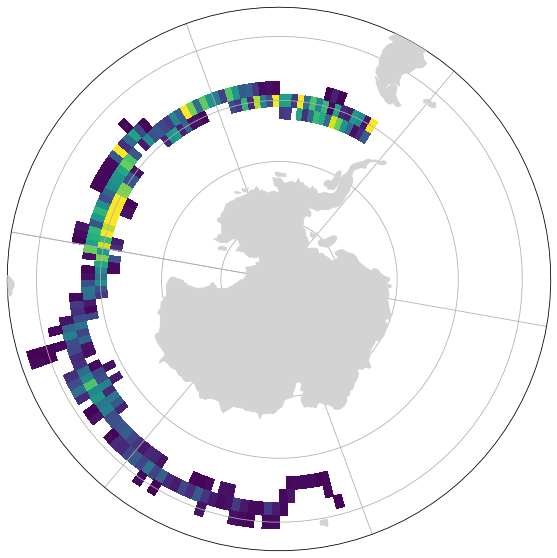

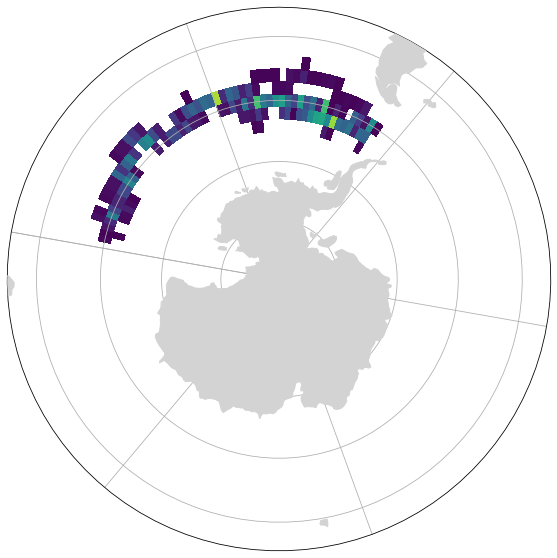

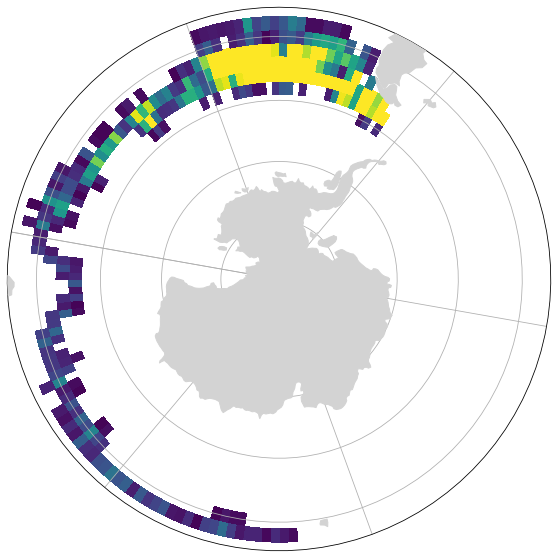

In [71]:
res = 2
lonG = np.arange(0,360,res)
latG = np.arange(-75,-45,res)
for site in sites:
    fig,ax = plt_SO()
    x = dssite[site]['lon']
    y = dssite[site]['lat']
    hs = histogram(x,y,bins=[lonG,latG],block_size=1)
    hs = hs.where((hs!=0))
    im=ax.pcolormesh(hs['lon_bin'],hs['lat_bin'],
                     hs.transpose(),
                     transform=ccrs.PlateCarree())
    im.set_clim([0,100])